https://pinkwink.kr/1124

In [23]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import copy

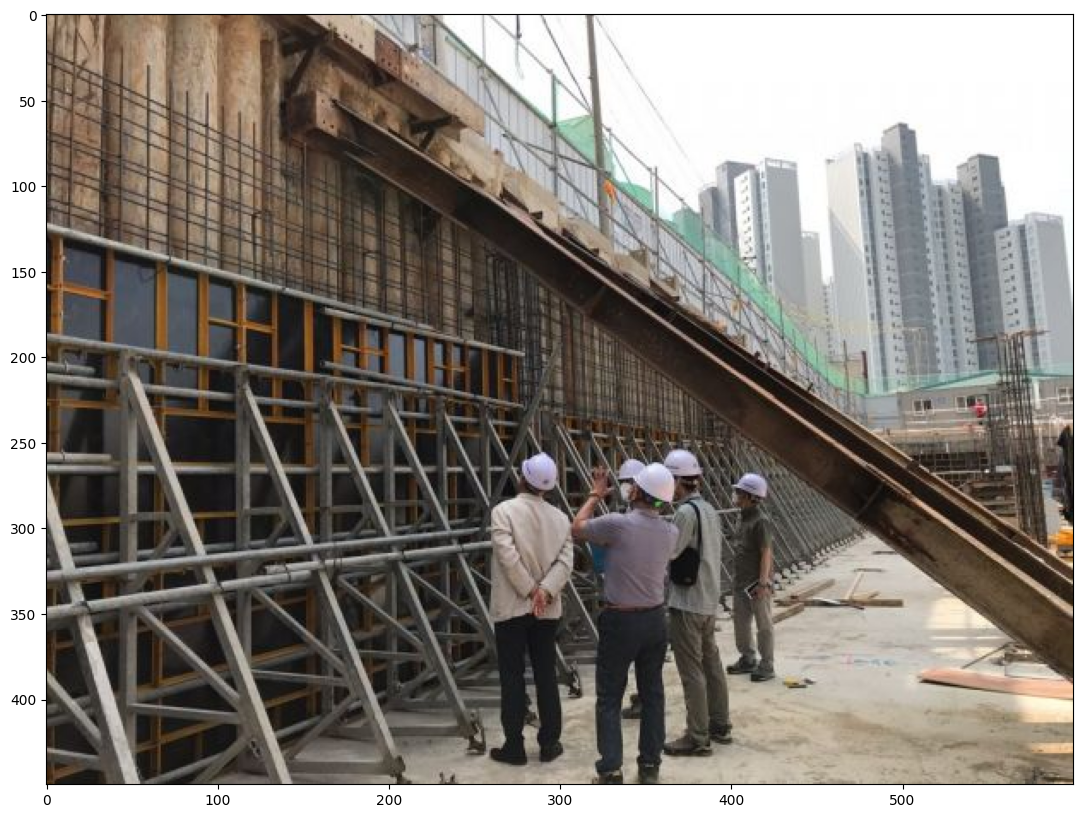

In [24]:
Image = cv.imread(r'E:\GithubProjects\KagglePractice\HelmetDetection\TestImage\test.jpg')
Height, Width = Image.shape[:2]

plt.figure(figsize=(16, 10))
# plt.imshow(img[:, :, ::-1])
plt.imshow(cv.cvtColor(Image, cv.COLOR_BGR2RGB))

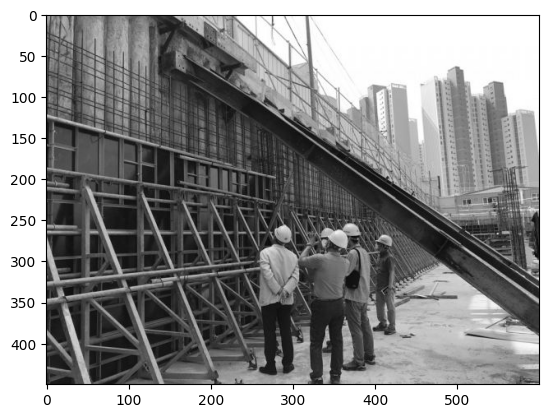

In [25]:
GrayImage = cv.cvtColor(Image, cv.COLOR_BGR2GRAY)
plt.imshow(cv.cvtColor(GrayImage, cv.COLOR_BGR2RGB))

In [26]:
FullBodyCascadePos = r'E:\GithubProjects\KagglePractice\HelmetDetection\models\haarcascade_fullbody.xml'

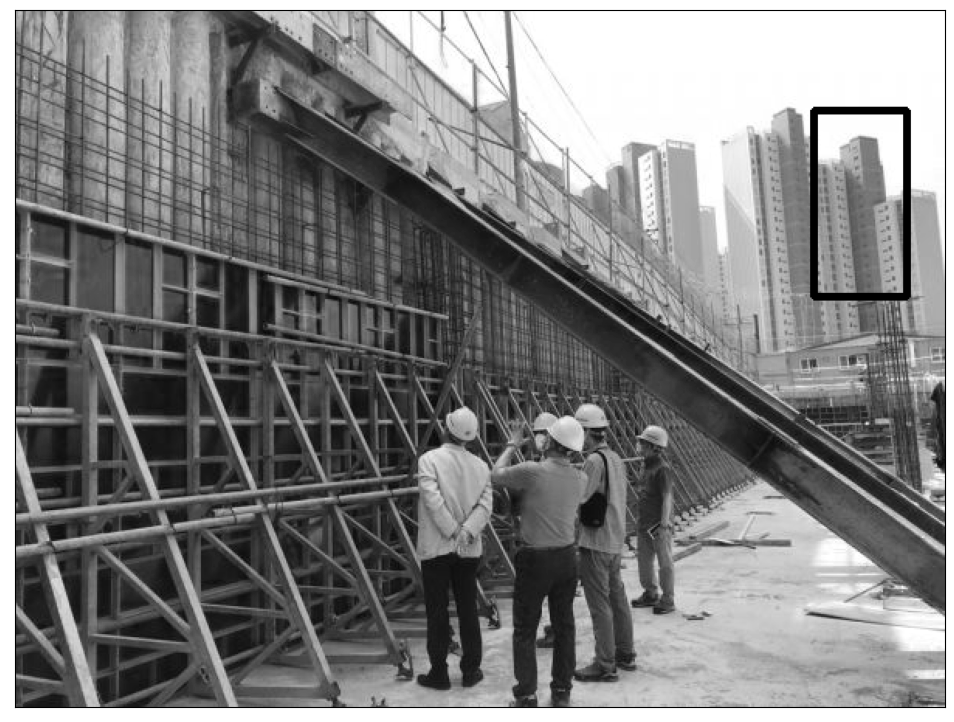

In [27]:
BodyCascade = cv.CascadeClassifier(FullBodyCascadePos)
BodyList = BodyCascade.detectMultiScale(GrayImage, 1.01, 10)

ShowImage = copy.deepcopy(Image)
for (x, y, w, h) in BodyList:
    cv.rectangle(ShowImage, (x,y), (x+w,y+h), (0,0,0), 3)

plt.figure(figsize=(12,12))
plt.imshow(ShowImage[:,:,-1], cmap='gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

좋은 결과가 아니군요  
다른 방법을 이용해봅시다.

https://github.com/kairess/torchvision_walkthrough/blob/master/segmentation.ipynb

필요 라이브러리를 다운받습니다

In [28]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)

pytorch 1.13.1+cpu
torchvision 0.14.1+cpu


각 객체마다 적용할 색을 지정해줍니다

In [74]:
IMG_SIZE = 480

COLORS = np.array([
    (0, 0, 0),       # 0=background
    (128, 0, 0),     # 1=aeroplane
    (0, 128, 0),     # 2=bicycle
    (128, 128, 0),   # 3=bird
    (0, 0, 128),     # 4=boat
    (128, 0, 128),   # 5=bottle
    (0, 128, 128),   # 6=bus
    (128, 128, 128), # 7=car
    (255, 255, 127), # 8=cat
    (192, 0, 0),     # 9=chair
    (64, 128, 0),    # 10=cow
    (192, 128, 0),   # 11=dining table
    (64, 0, 128),    # 12=dog
    (192, 0, 128),   # 13=horse
    (64, 128, 128),  # 14=motorbike
    (255, 255, 255), # 15=person
    (0, 64, 0),      # 16=potted plant
    (128, 64, 0),    # 17=sheep
    (0, 192, 0),     # 18=sofa
    (128, 192, 0),   # 19=train
    (0, 64, 128)     # 20=tv/monitor
])

모델을 다운로드해줍니다

In [30]:
deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

c:\Users\th070\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\th070\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


이미지를 불러옵니다

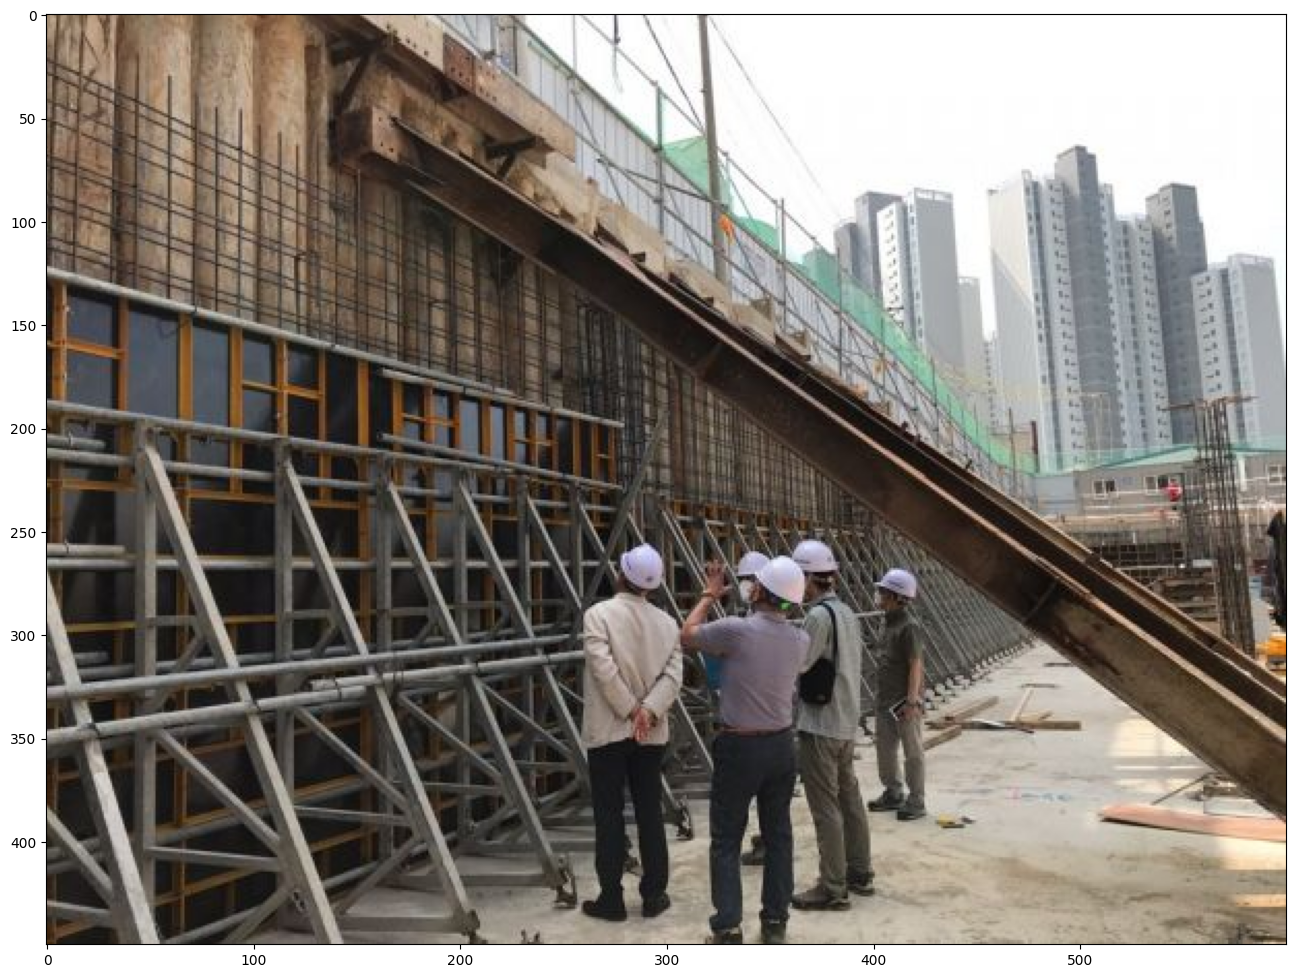

In [31]:
img = Image.open(r'E:\GithubProjects\KagglePractice\HelmetDetection\TestImage\test.jpg')

plt.figure(figsize=(16, 16))
plt.imshow(img)

이제 이미지를 텐서로 변환할 차례입니다!  

In [32]:
# T.Compose 는 리스트 안에 있는 작업을 차례차례 수행해줘라 입니다
trf = T.Compose([
    T.Resize(IMG_SIZE), # 이미지의 너비를 IMG_SIZE 로 설정합니다.
#     T.CenterCrop(IMG_SIZE), # 정 사각형으로 만들고 싶을 땐 이걸 씁니다
    T.ToTensor(),  # 이미지를 파이토치 텐서로 변경합니다. 이 때 값은 0, 1 사이 입니다.
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
	# 이미지는 명도, 채도가 전부 다르기 때문에 이를 평균과 표준편차로 설정해줄 필요가 있습니다
	# https://eehoeskrap.tistory.com/463
])

input_img = trf(img).unsqueeze(0)
# 차원을 하나 추가해줍니다
# (3,) -> (1,3)
# https://wikidocs.net/52846

# 추가하는 이유는 모델이 그렇게 설계됐기 때문입니당!
# (아마 여러 이미지를 동시에 예측하려는 이유 때문일 것으로 추정..)

모델에게 예측해달라고 합니다  
저흰 out 만 쓸 겁니다  

In [33]:
out = deeplab(input_img)['out']

print(out.shape)

torch.Size([1, 21, 480, 640])


반환 값은 각각 이렇습니다  
batch_size, classes, ImageWidth, ImageHeight

In [34]:
out = torch.argmax(out.squeeze(), dim=0)
out = out.detach().cpu().numpy()

print(out.shape)
print(np.unique(out))

(480, 640)
[ 0 15]


색칠

In [35]:
def seg_map(img, n_classes=21):
    rgb = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for c in range(n_classes):
        idx = img == c

        rgb[idx] = COLORS[c]

    return rgb

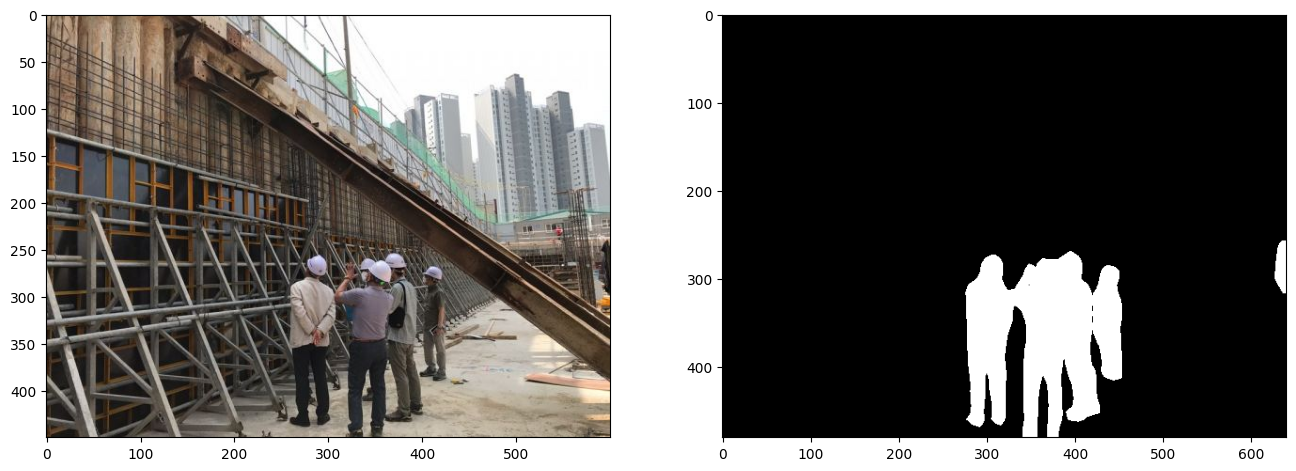

In [75]:
out_seg = seg_map(out)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
ax[0].imshow(img)
ax[1].imshow(out_seg)

오 괜찮다!  
하지만 우측에 사람이 아닌데도 노이즈가 끼여있다  

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
255


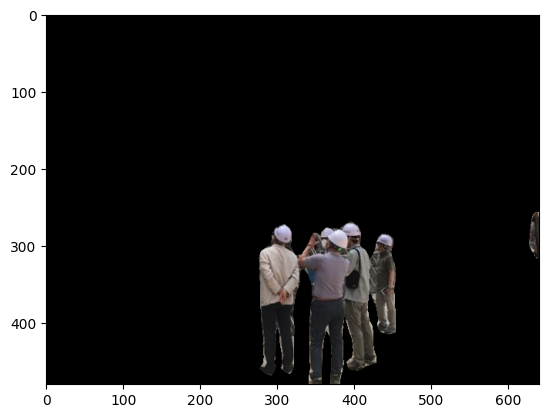

In [77]:
OriginalRescaledImage = copy.deepcopy(img)
OriginalRescaledImage = OriginalRescaledImage.resize((640,480))
OriginalRescaledImage = np.asarray(OriginalRescaledImage)
plt.imshow(OriginalRescaledImage & out_seg)
print(type(OriginalRescaledImage), type(out_seg))
print((OriginalRescaledImage + out_seg).max())

https://github.com/kairess/torchvision_walkthrough/blob/master/keypoints.ipynb

In [78]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)

pytorch 1.13.1+cpu
torchvision 0.14.1+cpu


In [79]:
IMG_SIZE = 480
THRESHOLD = 0.95

In [80]:
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True).eval()

c:\Users\th070\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\th070\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to C:\Users\th070/.cache\torch\hub\checkpoints\keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:26<00:00, 9.06MB/s] 


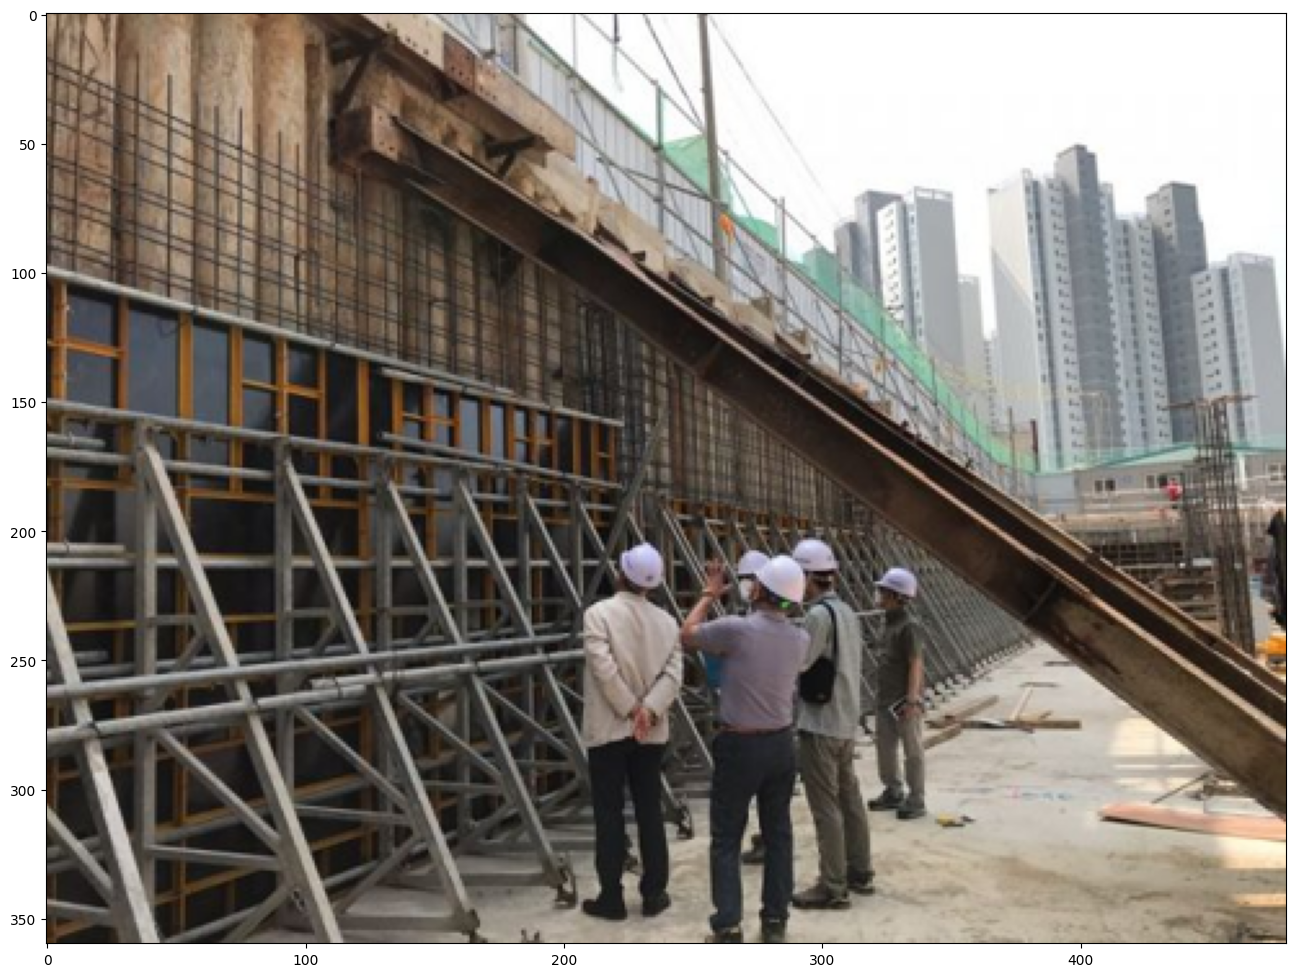

In [81]:
img = Image.open(r'E:\GithubProjects\KagglePractice\HelmetDetection\TestImage\test.jpg')
img = img.resize((IMG_SIZE, int(img.height * IMG_SIZE / img.width)))

plt.figure(figsize=(16, 16))
plt.imshow(img)

In [82]:
trf = T.Compose([
    T.ToTensor()
])

input_img = trf(img)

print(input_img.shape)

torch.Size([3, 360, 480])


In [83]:
out = model([input_img])[0]

print(out.keys())

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])


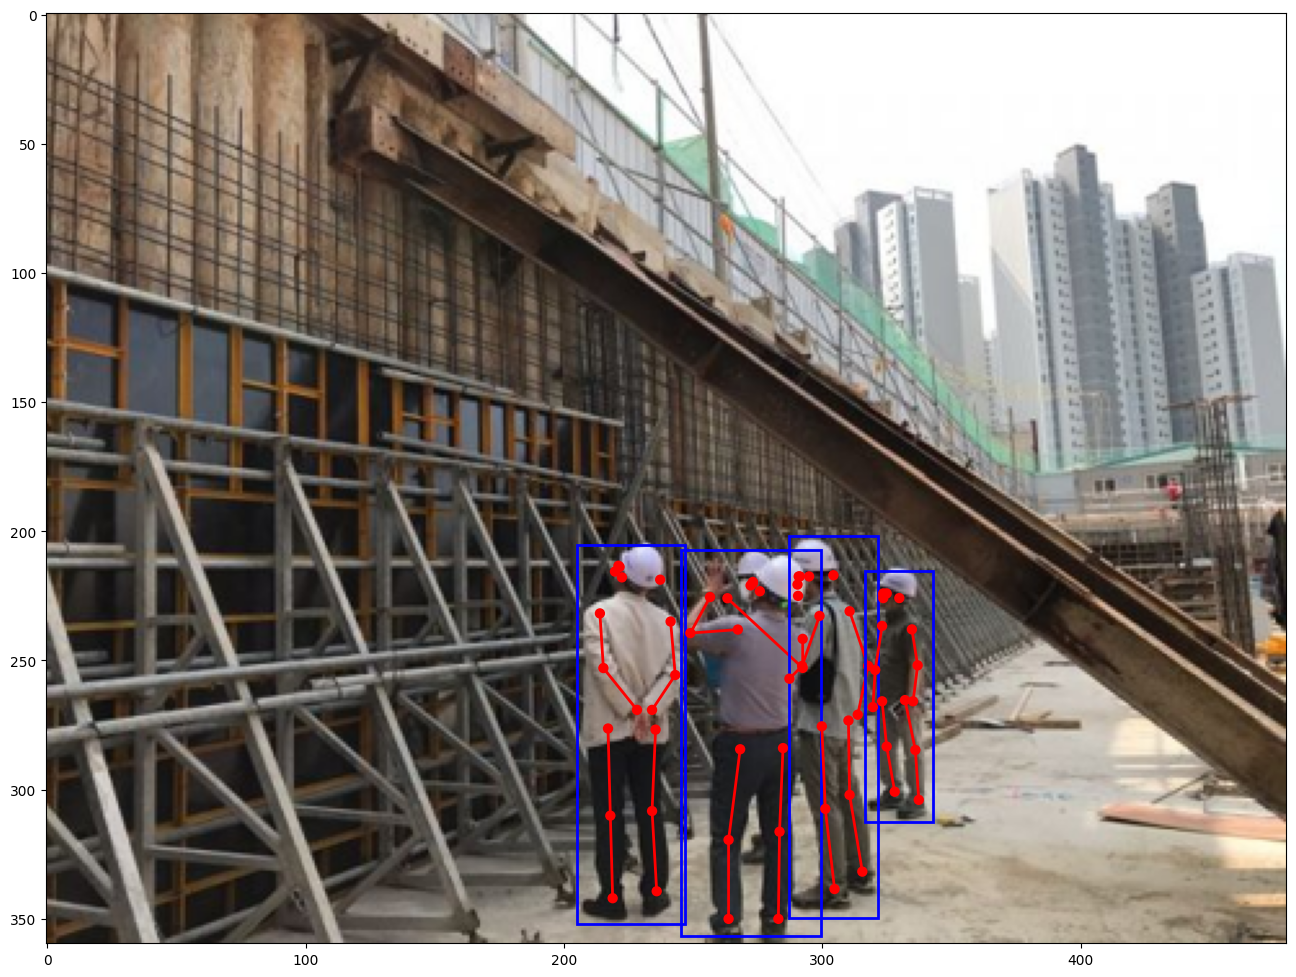

In [84]:
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO
]

fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(img)

for box, score, keypoints in zip(out['boxes'], out['scores'], out['keypoints']):
    score = score.detach().numpy()

    if score < THRESHOLD:
        continue

    box = box.detach().numpy()
    keypoints = keypoints.detach().numpy()[:, :2]

    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

    # 17 keypoints
    for k in keypoints:
        circle = patches.Circle((k[0], k[1]), radius=2, facecolor='r')
        ax.add_patch(circle)
    
    # draw path
    # left arm
    path = Path(keypoints[5:10:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
    ax.add_patch(line)
    
    # right arm
    path = Path(keypoints[6:11:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
    ax.add_patch(line)
    
    # left leg
    path = Path(keypoints[11:16:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
    ax.add_patch(line)
    
    # right leg
    path = Path(keypoints[12:17:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
    ax.add_patch(line)

오~ 잘 나왔다!

https://github.com/kairess/torchvision_walkthrough/blob/master/keypoints.ipynb 이걸 써야겠다